## 学習と精度を確認する
- 年次ホールドアウト + StratifiedKFold（TF‑IDFはfold内fit, LightGBM）
- 直近 TEST_LAST_N 年を最終テストとして完全にホールドアウト
- それ以前のデータのみで StratifiedKFold を実施（情報リーク防止のため TF‑IDF は fold学習データでfit）
- OOF で 閾値最適化（macro_f1 または balanced_accuracy）

In [687]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ====== パラメータ（必要に応じて変更） ======
RANDOM_SEED = 42
N_SPLITS = 6
# 列名
TEXT_COL = "description"          # テキスト列
LABEL_BINARY_COL = "eval_binary"  # 目的変数（0/1）
YEAR_COL = "project_start_year"   # 年度列（数値化可能であること）
THRESHOLD = 100 # 閾値
THRESH_OBJECTIVE = "balanced_accuracy"  # 閾値最適化の指標

# テストに使う直近年数
TEST_LAST_N = 5                  # 例: 直近2年をテスト

# TF-IDF
TFIDF_MAX_FEATURES = 5000
TFIDF_MIN_DF = 3
TFIDF_NGRAM = (1, 2)
# テキストベクトル化の方式を切替
# - 'char': 日本語向けに手軽な文字n-gram（デフォルト）
# - 'word': 形態素解析（fugashi）で単語n-gram
TEXT_TOKENIZER = 'char'  # 'word' or 'word'
CHAR_NGRAM = (2, 4)      # analyzer='char_wb' 時の ngram_range
WORD_NGRAM = (1, 1)      # analyzer='word'（形態素）の ngram_range

# cost_success_flg, duration_success_flg, total_eval
SOURCE_ORDINAL_COL = "total_eval"

# LightGBM デフォルト
LGB_PARAMS = dict(
    objective="binary",
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    is_unbalance=True,  # クラス不均衡設定
)

In [688]:
import pandas as pd
df = pd.read_csv("../df_check_ml.csv")  # ←必要ならCSV読み込み

df.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

In [689]:
# 分布の確認
all_records = len(df)
print(f'all records {all_records}')

true = len(df[df[LABEL_BINARY_COL]==1])
print(f'flg true records {true}')

print(f'flg false records {all_records - true}')

all records 2227
flg true records 1650
flg false records 577


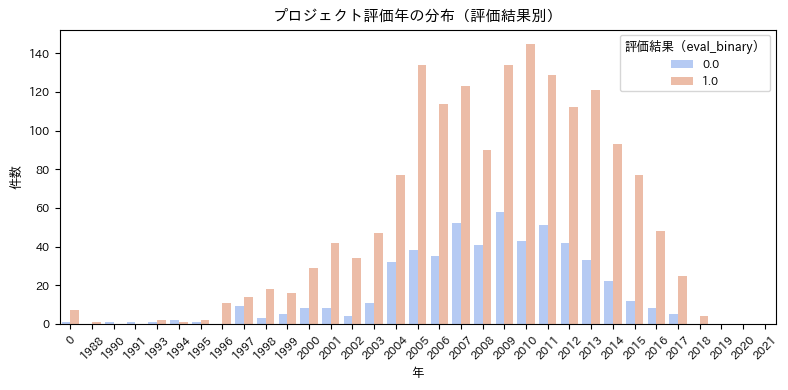

In [690]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df,
    x=YEAR_COL,
    hue="eval_binary",
    palette="coolwarm"
)
plt.title("プロジェクト評価年の分布（評価結果別）", fontsize=11)  # タイトル小さく
plt.xlabel("年", fontsize=9)                     # 軸ラベル小さく
plt.ylabel("件数", fontsize=9)
plt.xticks(rotation=45, fontsize=8)                              # x軸目盛りの文字サイズ
plt.yticks(fontsize=8)                                           # y軸目盛りの文字サイズ
plt.legend(title="評価結果（eval_binary）", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()

In [691]:
# 利用するテキストの特徴量を生成
df['description'] = df['background']+df['description']

In [692]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, balanced_accuracy_score
)
import lightgbm as lgb
from pathlib import Path
from typing import Optional, Callable

def build_struct_features(df: pd.DataFrame, TEXT_COL: str, LABEL_BINARY_COL: str, features: list):
    if TEXT_COL not in df.columns:
        raise ValueError(f"テキスト列 {TEXT_COL} が見つかりません。")
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"featuresに指定した列が見つかりません: {missing}")
    df2 = df.copy()
    df2[TEXT_COL] = df2[TEXT_COL].fillna("")
    use_cols = features + [LABEL_BINARY_COL, YEAR_COL]
    df_cln = df2.dropna(subset=use_cols).copy()
    if df_cln.empty:
        raise ValueError("欠損除外でデータが空になりました。列名や欠損を確認してください。")
    X_struct = df_cln[features].copy()
    y = df_cln[LABEL_BINARY_COL].astype(int)
    # One-Hot
    cat_cols = X_struct.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_struct.columns if c not in cat_cols]
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat = ohe.fit_transform(X_struct[cat_cols]) if cat_cols else np.empty((len(X_struct),0))
    X_num = X_struct[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()
    texts = df_cln[TEXT_COL].to_numpy()
    return df_cln, texts, y, X_num, X_cat, num_cols, cat_cols

def _ja_tokenizer_or_none() -> Optional[Callable[[str], list]]:
    """Return a fugashi tokenizer function if available, else None."""
    try:
        from fugashi import Tagger  # type: ignore
    except Exception:
        return None
    tagger = Tagger()
    def tokenize_ja(text: str) -> list:
        return [w.surface for w in tagger(text)]
    return tokenize_ja

def create_vectorizer():
    """Create a TfidfVectorizer based on TEXT_TOKENIZER setting."""
    if TEXT_TOKENIZER == 'word':
        tok = _ja_tokenizer_or_none()
        if tok is None:
            print("[WARN] fugashi not available. Falling back to char n-gram.")
        else:
            return TfidfVectorizer(
                tokenizer=tok,
                token_pattern=None,
                analyzer='word',
                ngram_range=WORD_NGRAM,
                min_df=TFIDF_MIN_DF,
                max_features=TFIDF_MAX_FEATURES,
            )
    # default: char n-gram
    return TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=CHAR_NGRAM,
        min_df=TFIDF_MIN_DF,
        max_features=TFIDF_MAX_FEATURES,
    )

def year_holdout_indices(df_cln: pd.DataFrame, YEAR_COL: str, last_n: int = 2):
    if YEAR_COL not in df_cln.columns:
        raise ValueError(f"YEAR_COL {YEAR_COL} が見つかりません。")
    years = pd.to_numeric(df_cln[YEAR_COL], errors="coerce")
    if years.isna().any():
        raise ValueError(f"YEAR_COL {YEAR_COL} に非数値/NaNがあります。")
    max_year = int(years.max())
    cut_years = list(range(max_year - last_n + 1, max_year + 1))
    test_mask = years.isin(cut_years)
    train_mask = ~test_mask
    train_idx = np.where(train_mask.values)[0]
    test_idx = np.where(test_mask.values)[0]
    return train_idx, test_idx, cut_years

def find_best_threshold(y_true, proba, objective="macro_f1"):
    qs = np.unique(np.quantile(proba, np.linspace(0.01, 0.99, 199)))
    ls = np.linspace(0.01, 0.99, 199)
    grid = np.unique(np.concatenate([qs, ls]))
    best_t, best_score = 0.5, -1.0
    for t in grid:
        pred = (proba >= t).astype(int)
        if objective == "macro_f1":
            score = f1_score(y_true, pred, average="macro", zero_division=0)
        elif objective == "balanced_accuracy":
            score = balanced_accuracy_score(y_true, pred)
        else:
            raise ValueError("objective must be 'macro_f1' or 'balanced_accuracy'")
        if score > best_score:
            best_score, best_t = score, t
    return float(best_t), float(best_score)



In [693]:

ohe_col = [
    #'project_start_year',
    'country',
    'region_detail',
    'type',
    '分野'
]
df = pd.get_dummies(df, columns=ohe_col)



In [694]:
for c in df.columns:
    print(c)

Unnamed: 0_x
file
eval_year
evaluator_group
evaluator
project_cost_plan
project_cost_act
プロジェクト期間開始_計画時
プロジェクト期間終了_計画時
プロジェクト期間開始_実績
プロジェクト期間終了_実績
project_duration_plan
project_duration_act
妥当性評価
整合性評価
有効性評価
インパクト評価
効率性評価
効率性_コスト
効率性_期間
持続性評価
適応・貢献評価
付加価値・創造価値評価
総合評価
備考
案件名
連番
region
alpha2
alpha3
project_start_year
project_end_year
join_flg_x
Year
external_eval_flg
その他_flg_fix
インフラ_flg_fix
エネルギー一般_flg_fix
人材・教育_flg_fix
保健・社会福祉_flg_fix
公益事業一般_flg_fix
商業経営_flg_fix
工業_flg_fix
放送_flg_fix
林業・森林保全_flg_fix
水産_flg_fix
水資源開発_flg_fix
海運_flg_fix
測量・地図_flg_fix
災害・食料援助_flg_fix
災害対策_flg_fix
環境_flg_fix
畜産_flg_fix
社会基盤一般_flg_fix
航空・空港_flg_fix
行政一般_flg_fix
観光一般_flg_fix
貿易_flg_fix
農業一般_flg_fix
通信・放送一般_flg_fix
都市計画・土地造成_flg_fix
金融_flg_fix
開発_flg_fix
cost_rate
duration_rate
total_eval
Unnamed: 0_y
freedom_house_score
join_flg_y
population
gdp_growth
control_of_corruption
government_effectiveness
political_stability
regulatory_quality
rule_of_law
voice_and_accountability
title
conclusion
validity
inpact
e

In [695]:
# 例: 既存ノートのfeaturesを再掲。必要に応じて変更/追加してください。
features = [
    'project_cost_plan', 
    'project_duration_plan', 
    'control_of_corruption', 
    'government_effectiveness', 
    'political_stability', 
    'regulatory_quality', 
    'rule_of_law', 
    'voice_and_accountability', 
    'freedom_house_score', 
    'gdp_growth', 
    'population', 
]

# one-hot列のパターンをまとめて追加する場合はここで拡張してOK
country_columns = [c for c in df.columns if c.startswith('country_')]
type_columns = [c for c in df.columns if c.startswith('type_')]
project_start_year_columns = [c for c in df.columns if c.startswith('project_start_year')]
region_columns = [c for c in df.columns if c.startswith('region_detail')]
sector_columns = [c for c in df.columns if 'flg_fix' in c]

features = features + country_columns + type_columns + sector_columns + region_columns

In [696]:
# df が必要です（CSV読込または既存変数）
assert 'df' in globals(), "事前に df を用意してください（CSVから読むか、メモリ上にdfがある状態）。"

# 構造化＋テキストの前処理
df_cln, texts, y, X_num, X_cat, _, _ = build_struct_features(df, TEXT_COL, LABEL_BINARY_COL, features)

# 年次ホールドアウト
train_idx, test_idx, years_test = year_holdout_indices(df_cln, YEAR_COL, last_n=TEST_LAST_N)
if len(test_idx) == 0:
    raise ValueError("テストセットが空です。YEAR_COL/TEST_LAST_Nを確認してください。")

X_struct_all = np.hstack([X_num, X_cat])
X_train_struct = X_struct_all[train_idx]
X_test_struct  = X_struct_all[test_idx]
X_train_text_raw = texts[train_idx]
X_test_text_raw  = texts[test_idx]
y_train = y.iloc[train_idx].to_numpy()
y_test  = y.iloc[test_idx].to_numpy()

print("=== Year-based split summary ===")
print(f"Years TEST: {years_test}")
print(f"Train size={len(train_idx)}, Test size={len(test_idx)}")
print(f"Train pos={int((y_train==1).sum())}, neg={int((y_train==0).sum())}")
print(f"Test  pos={int((y_test==1).sum())},  neg={int((y_test==0).sum())}")



# ===== Optuna: LightGBM ハイパーパラメータチューニング =====
# - 学習期間データのみを用いて inner CV の AUC を最大化

def _build_fold_mats(tr_local, va_local):
    # TF-IDF を fold 学習データで fit
    vec = create_vectorizer()
    X_tr_text = vec.fit_transform(X_train_text_raw[tr_local])
    X_va_text = vec.transform(X_train_text_raw[va_local])

    X_tr = np.hstack([X_train_struct[tr_local], X_tr_text.toarray()])
    X_va = np.hstack([X_train_struct[va_local], X_va_text.toarray()])
    y_tr = y_train[tr_local]
    y_va = y_train[va_local]
    return X_tr, X_va, y_tr, y_va

def objective(trial: 'optuna.Trial') -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 2e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "objective": "binary",
        "random_state": RANDOM_SEED,
        "n_jobs": -1,
    }

    kf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    scores = []
    for tr_local, va_local in kf_inner.split(X_train_struct, y_train):
        X_tr, X_va, y_tr, y_va = _build_fold_mats(tr_local, va_local)
        model = lgb.LGBMClassifier(**params)
        callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric="auc", callbacks=callbacks)
        proba = model.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, proba))
    return float(np.mean(scores))

# CV
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

oof_proba = np.zeros(len(y_train), dtype=float)
test_proba_folds = []
fold_rows = []

for fold, (tr_local, va_local) in enumerate(kf.split(X_train_struct, y_train), start=1):
    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")
    X_tr_struct = X_train_struct[tr_local]
    X_va_struct = X_train_struct[va_local]
    y_tr = y_train[tr_local]
    y_va = y_train[va_local]

    # TF-IDF: fold学習データでfit
    vec = create_vectorizer()
    X_tr_text = vec.fit_transform(X_train_text_raw[tr_local])
    X_va_text = vec.transform(X_train_text_raw[va_local])
    X_te_text = vec.transform(X_test_text_raw)

    X_tr = np.hstack([X_tr_struct, X_tr_text.toarray()])
    X_va = np.hstack([X_va_struct, X_va_text.toarray()])
    X_te = np.hstack([X_test_struct, X_te_text.toarray()])

    model = lgb.LGBMClassifier(**LGB_PARAMS)
    callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric="auc", callbacks=callbacks)

    va_proba = model.predict_proba(X_va)[:,1]
    oof_proba[va_local] = va_proba

    auc = roc_auc_score(y_va, va_proba)
    # 便宜上 0.5 での簡易指標も出す
    va_pred05 = (va_proba >= 0.5).astype(int)
    f1_05 = f1_score(y_va, va_pred05, average="macro", zero_division=0)
    bacc_05 = balanced_accuracy_score(y_va, va_pred05)
    fold_rows.append({"fold": fold, "AUC": auc, "MacroF1@0.5": f1_05, "BalAcc@0.5": bacc_05})

    test_proba = model.predict_proba(X_te)[:,1]
    test_proba_folds.append(test_proba)

import pandas as pd
cv_df = pd.DataFrame(fold_rows)
print("\n[CV metrics @0.5]")
print(cv_df)
print("\nMean ± Std")
print(cv_df[['AUC','MacroF1@0.5','BalAcc@0.5']].agg(['mean','std']))



=== Year-based split summary ===
Years TEST: [2014, 2015, 2016, 2017, 2018]
Train size=1666, Test size=291
Train pos=1260, neg=406
Test  pos=244,  neg=47

========== Fold 1/6 ==========
[LightGBM] [Info] Number of positive: 1050, number of negative: 338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264165
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 5046
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756484 -> initscore=1.133500
[LightGBM] [Info] Start training from score 1.133500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

OOF AUC: 0.6296
Best threshold by balanced_accuracy: t=0.705, score=0.5930

[Test report with optimized threshold]
Threshold used: 0.705
              precision    recall  f1-score   support

           0     0.2885    0.6383    0.3974        47
           1     0.9091    0.6967    0.7889       244

    accuracy                         0.6873       291
   macro avg     0.5988    0.6675    0.5931       291
weighted avg     0.8089    0.6873    0.7256       291


Confusion Matrix [rows=true, cols=pred] (labels: 0,1):


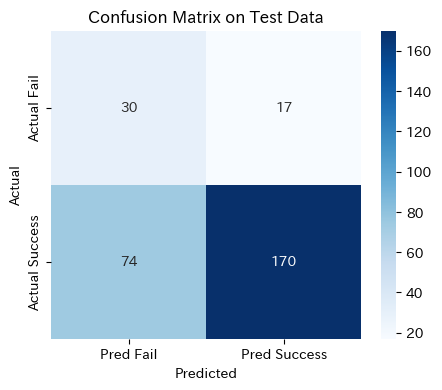

Test Balanced Accuracy: 0.6675
Test Macro F1: 0.5931


In [697]:
# OOF AUC（閾値非依存の参照値）
oof_auc = roc_auc_score(y_train, oof_proba)
print(f"OOF AUC: {oof_auc:.4f}")

# テスト確率はfoldモデルの平均
test_proba_mean = np.mean(np.column_stack(test_proba_folds), axis=1)

# 閾値最適化（デフォルト: Macro F1）
t_opt, score_opt = find_best_threshold(y_train, oof_proba, objective=THRESH_OBJECTIVE)
print(f"Best threshold by {THRESH_OBJECTIVE}: t={t_opt:.3f}, score={score_opt:.4f}")

y_test_pred = (test_proba_mean >= t_opt).astype(int)
print("\n[Test report with optimized threshold]")
print(f"Threshold used: {t_opt:.3f}")
print(classification_report(y_test, y_test_pred, digits=4))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0.0
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0.0
bal_acc_test = (recall_0 + recall_1) / 2
macro_f1_test = f1_score(y_test, y_test_pred, average="macro", zero_division=0)

print("\nConfusion Matrix [rows=true, cols=pred] (labels: 0,1):")
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Fail", "Pred Success"],
            yticklabels=["Actual Fail", "Actual Success"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix on Test Data")
plt.show()

print(f"Test Balanced Accuracy: {bal_acc_test:.4f}")
print(f"Test Macro F1: {macro_f1_test:.4f}")



In [698]:


out = Path("model_outputs_year_holdout")
out.mkdir(exist_ok=True, parents=True)

cv_df.to_csv(out/"cv_metrics.csv", index=False)

import numpy as np, json
np.save(out/"oof_proba.npy", oof_proba)
np.save(out/"test_proba.npy", np.array(test_proba_folds, dtype=float))  # 各foldごとのテスト確率（行:fold）
with open(out/"settings.json","w") as f:
    json.dump({
        "RANDOM_SEED": RANDOM_SEED,
        "N_SPLITS": N_SPLITS,
        "TEXT_COL": TEXT_COL,
        "LABEL_BINARY_COL": LABEL_BINARY_COL,
        "YEAR_COL": YEAR_COL,
        "TEST_LAST_N": TEST_LAST_N,
        "TFIDF_MAX_FEATURES": TFIDF_MAX_FEATURES,
        "TFIDF_MIN_DF": TFIDF_MIN_DF,
        "TFIDF_NGRAM": TFIDF_NGRAM,
        "LGB_PARAMS": LGB_PARAMS,
        "THRESH_OBJECTIVE": THRESH_OBJECTIVE
    }, f, indent=2)

print(f"Saved metrics and arrays to: {out.resolve()}")



Saved metrics and arrays to: /mnt/works/y-ito-8d3/works/check/analyze/model_outputs_year_holdout


In [699]:

TFIDF_MAX_FEATURES = 1000
print('TFIDF_MAX_FEATURES set to', TFIDF_MAX_FEATURES)



TFIDF_MAX_FEATURES set to 1000


X_train_full shape: (1666, 1201), features: 1201
[LightGBM] [Info] Number of positive: 1134, number of negative: 365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133254
[LightGBM] [Info] Number of data points in the train set: 1499, number of used features: 1061
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756504 -> initscore=1.133609
[LightGBM] [Info] Start training from score 1.133609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


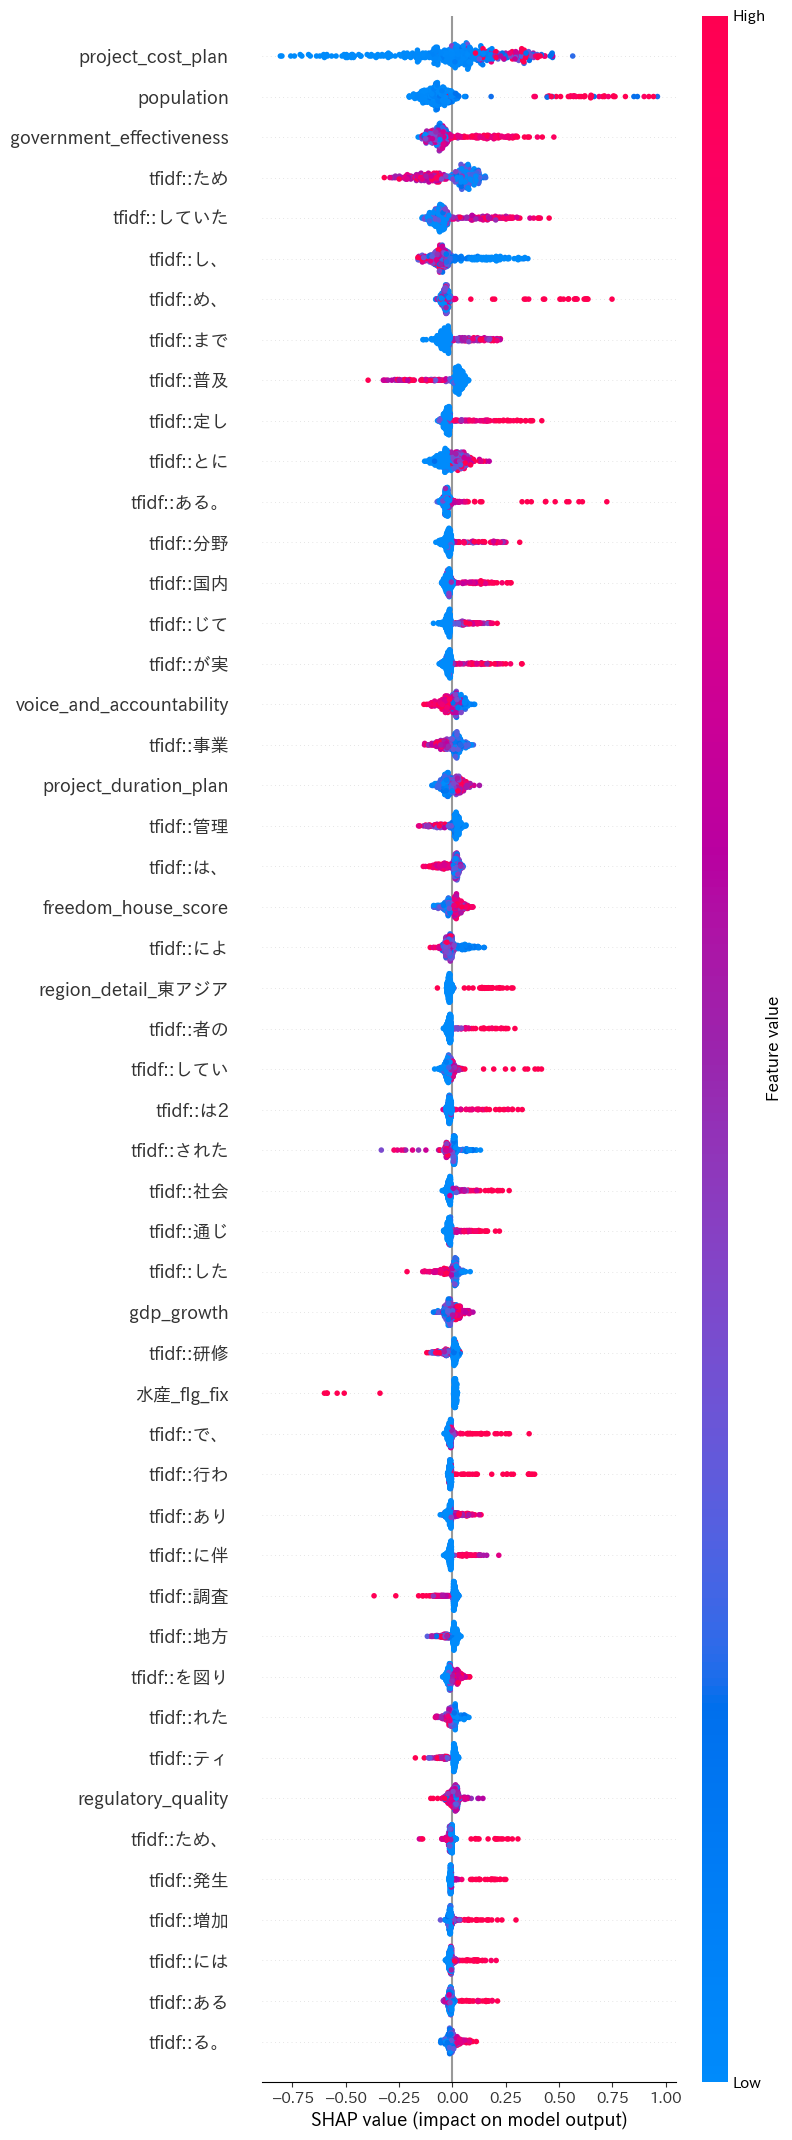

Saved: model_outputs_year_holdout/shap_importance_top.csv (top features by mean |SHAP|)


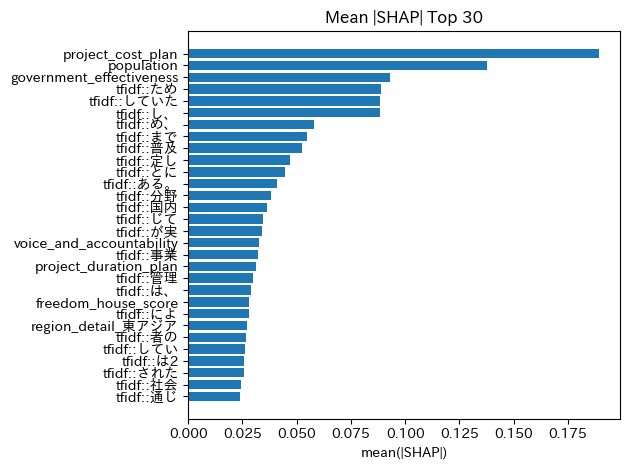

In [700]:


import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from pathlib import Path

# 必須変数の存在チェック
required_vars = ['df_cln','features','train_idx','test_idx','TEXT_COL','YEAR_COL','LABEL_BINARY_COL','LGB_PARAMS']
for v in required_vars:
    assert v in globals(), f"変数 {v} が見つかりません。上のセルを順に実行してください。"

# 1) 学習・テストの行を抽出
df_train = df_cln.iloc[train_idx].copy()
df_test  = df_cln.iloc[test_idx].copy()

y_train_full = df_train[LABEL_BINARY_COL].astype(int).to_numpy()
y_test_full  = df_test[LABEL_BINARY_COL].astype(int).to_numpy()

# 2) 構造化: 学習データでOneHotEncoder fit
X_struct_train_df = df_train[features].copy()
X_struct_test_df  = df_test[features].copy()

cat_cols = X_struct_train_df.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = [c for c in X_struct_train_df.columns if c not in cat_cols]

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat_train = ohe.fit_transform(X_struct_train_df[cat_cols]) if cat_cols else np.empty((len(X_struct_train_df),0))
X_cat_test  = ohe.transform(X_struct_test_df[cat_cols]) if cat_cols else np.empty((len(X_struct_test_df),0))
cat_feature_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []

X_num_train = X_struct_train_df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()
X_num_test  = X_struct_test_df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()
num_feature_names = list(num_cols)

# 3) テキスト: 学習データでTF-IDF fit（max_features=1000）
vec = create_vectorizer()
X_text_train = vec.fit_transform(df_train[TEXT_COL].fillna("").to_numpy())
X_text_test  = vec.transform(df_test[TEXT_COL].fillna("").to_numpy())
text_feature_names = [f"tfidf::{t}" for t in vec.get_feature_names_out()]

# dense化（LightGBM sklearn APIに合わせる）
X_train_full = np.hstack([X_num_train, X_cat_train, X_text_train.toarray()])
X_test_full  = np.hstack([X_num_test,  X_cat_test,  X_text_test.toarray()])
feature_names = num_feature_names + cat_feature_names + text_feature_names

print(f"X_train_full shape: {X_train_full.shape}, features: {len(feature_names)}")

# 4) 学習期間内で小さな検証セットを切って早期停止
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
tr_idx, va_idx = next(sss.split(X_train_full, y_train_full))
X_tr, X_va = X_train_full[tr_idx], X_train_full[va_idx]
y_tr, y_va = y_train_full[tr_idx], y_train_full[va_idx]

model = lgb.LGBMClassifier(**LGB_PARAMS)
callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric="auc", callbacks=callbacks)

# 5) SHAP計算（サンプル数を抑制）
n_sample = min(400, X_train_full.shape[0])
rng = np.random.default_rng(42)
idx_sample = rng.choice(np.arange(X_train_full.shape[0]), size=n_sample, replace=False)
X_shap = X_train_full[idx_sample]
y_shap = y_train_full[idx_sample]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# shap_values の戻りが list の場合（古いshapで二値タスクはリスト）に対応
if isinstance(shap_values, list):
    # positiveクラスの寄与を使用（1を正例と仮定）
    sv = shap_values[1]
else:
    sv = shap_values  # (n_sample, n_features)

# 6) summary_plot（上位50特徴）
plt.figure()
shap.summary_plot(sv, X_shap, feature_names=feature_names, max_display=50, show=True)

# 7) 平均絶対SHAPで上位をCSV保存＋棒グラフ
mean_abs_shap = np.mean(np.abs(sv), axis=0)
imp_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs_shap}).sort_values("mean_abs_shap", ascending=False)
out = Path("model_outputs_year_holdout")
out.mkdir(exist_ok=True, parents=True)
imp_df.to_csv(out/"shap_importance_top.csv", index=False)
print(f"Saved: {out/'shap_importance_top.csv'} (top features by mean |SHAP|)")

# 棒グラフ（上位30）
topn = 30
top_df = imp_df.head(topn).iloc[::-1]  # 反転して上から下へ
plt.figure()
plt.barh(top_df["feature"], top_df["mean_abs_shap"])
plt.title(f"Mean |SHAP| Top {topn}")
plt.xlabel("mean(|SHAP|)")
plt.tight_layout()
plt.show()



In [701]:
features

['project_cost_plan',
 'project_duration_plan',
 'control_of_corruption',
 'government_effectiveness',
 'political_stability',
 'regulatory_quality',
 'rule_of_law',
 'voice_and_accountability',
 'freedom_house_score',
 'gdp_growth',
 'population',
 'country_(アジア)',
 'country_(アフリカ)',
 'country_(中南米)',
 'country_(中東)',
 'country_(大洋州)',
 'country_アゼルバイジャン',
 'country_アフガニスタン',
 'country_アフリカ開発銀行',
 'country_アルジェリア',
 'country_アルゼンチン',
 'country_アルバニア',
 'country_アルメニア',
 'country_アンゴラ',
 'country_アンティグア・バーブーダ',
 'country_イラク',
 'country_イラン',
 'country_インド',
 'country_インドネシア',
 'country_ウガンダ',
 'country_ウクライナ',
 'country_ウズベキスタン',
 'country_エクアドル',
 'country_エジプト',
 'country_エスワティニ',
 'country_エチオピア',
 'country_エリトリア',
 'country_エルサルバドル',
 'country_カザフスタン',
 'country_カメルーン',
 'country_カンボジア',
 'country_カーボベルデ',
 'country_ガイアナ',
 'country_ガボン',
 'country_ガンビア',
 'country_ガーナ',
 'country_キューバ',
 'country_キリバス',
 'country_キルギス',
 'country_ギニア',
 'country_ギニアビサウ',
 'country_クロアチア',
 'count